# ASTR 19 Final Project

## Step 3: Following the Tutorial

Import libraries & set up

In [103]:
import numpy as np
import sep as sep

In [104]:
import astropy as astropy
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [105]:
plt.style.use("Downloads/astr19_matplotlib_defaults.txt")

### Reading an example image from FITS file and display it

Use astropy to open the FITS file and get its data.

In [106]:
#read image into standard 2-d numpy array
data = fits.open("Downloads/image.fits")
image_data = fits.getdata("Downloads/image.fits", ext=0)

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


Use numpy to find the mean and standard deviation of the image data and show it on a figure with a colorbar.

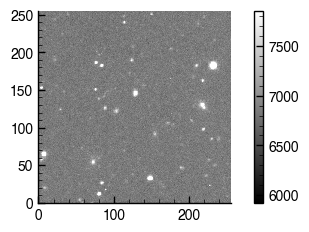

In [107]:
#show the image
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('final-project-image1.png', bbox_inches='tight', dpi=400, facecolor='white')

## Background subtraction in sep
### background estimation & source detection are separate steps in SEP

In [108]:
#measure a spatially varying background on the image
bkg = sep.Background(image_data)

In [109]:
#get a 'global' mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [110]:
#evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) is equivalent to above

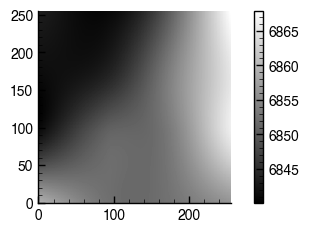

In [111]:
#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('final-project-image2.png', bbox_inches='tight', dpi=400, facecolor='white')

In [112]:
#evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

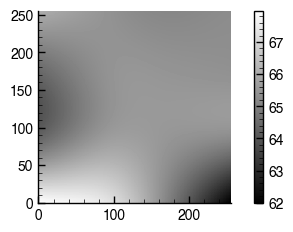

In [113]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('final-project-image3.png', bbox_inches='tight', dpi=400, facecolor='white')

In [114]:
#subtract the background
data_sub = image_data - bkg

## Object detection on background-subtracted data
### setting detection threshold to be a constant value of 1.5σ

In [115]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [116]:
#how many objects were detected
len(objects)

68

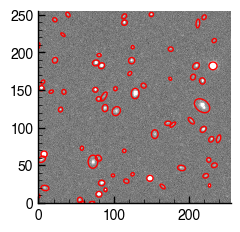

In [117]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range (len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                    width=6*objects['a'][i],
                    height=6*objects['b'][i],
                    angle=objects['theta'][i] * 180./np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('final-project-image4.png', bbox_inches='tight', dpi=400, facecolor='white')

'objects' has many other fields!

In [118]:
#available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry

Perform simple circular aperture photometry with a 3-pixel radius at the locations of the objects

In [119]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'],
                                    objects['y'], 3.0,
                                    err=bkg.globalrms, gain=1.0)
#flux, fluxerr, and flag are 1-d arrays with 1 entry/object

In [120]:
#show the first 10 objects results
for i in range(10):
    print("object {:d}: flux={:f} +/- {:f}". format(i, flux[i], fluxerr[i]))

object 0: flux=2249.157852 +/- 291.027799
object 1: flux=3092.217500 +/- 291.592199
object 2: flux=5949.861113 +/- 356.561993
object 3: flux=1851.419824 +/- 295.028805
object 4: flux=72736.380312 +/- 440.172199
object 5: flux=3860.756895 +/- 352.163163
object 6: flux=6418.902715 +/- 357.458957
object 7: flux=2210.714238 +/- 350.791233
object 8: flux=2741.609297 +/- 352.277749
object 9: flux=20916.877363 +/- 376.966141
